In [1]:
# Questions
# Do we do HWE check on gangstr? check chr21:8993159
# Compute MI rate per locus, can filter on that?
# check low MI rate trios
# check sample whose trio we said was missing

In [2]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import numpy as np
import os
import pandas as pd


path = f"/expanse/projects/gymreklab/helia/ensembl/1000Genomes-TR-Analysis/mend/result/mend_gt_all.tab"
data = pd.read_csv(path, sep="\t", 
    names=["chrom","pos","motif","sample","MI","Score","gbs", "method"])
print(len(data[data['MI'] == True]) / len(data))

0.9409555316769832


In [6]:
# def more_than_two(l):
#     cnt = 0
#     for x in l:
#         if x == "no_call":
#             continue
#         cnt += 1
#     return cnt >= 2
            
    
# data = pd.read_csv("result/mend_gt_chr21_raw.tab", sep="\t", 
#     names=["chrom","pos","motif","sample","method","gbs","MI","Score","caller","raw_mend"])
# data['raw_mend'] = data['raw_mend'].str.split(",")
# data['raw_false'] = data['raw_mend'].apply(lambda x: 'False' in x)
# data['more_than_two'] = data['raw_mend'].apply(lambda x: more_than_two(x))
# had_false = data[(data['raw_false'] == True) & (data['more_than_two'] == True)]
# filtered = had_false[had_false['MI'] == True]
# display(data[(data['raw_false'] == False) & (data['MI'] == False)])
# display(filtered)

In [7]:
# pos_callers = data[['chrom', 'pos', 'caller']].drop_duplicates()
# pos_callers = pos_callers[(pos_callers['caller'] == 'hipstr,gangstr') | (pos_callers['caller'] == 'gangstr,hipstr')]
# pos_callers['end'] = pos_callers['pos'] + 10
# pos_callers[['chrom', 'pos', 'end']].to_csv("review/hipstr_gangstr_coordinates.txt", sep = "\t", index = False,
#                                            header = False)

In [8]:
# gangstr_data = pd.read_csv("review/gangstr_mend.txt", sep="\t", 
#      names=["chrom","pos","motif","sample","MI","Score"])
# hipstr_data = pd.read_csv("review/hipstr_men_len.txt", sep="\t", 
#      names=["chrom","pos","motif","sample","MI","Score"])
# ensemble_data = pd.read_csv("result/mend_len_chr21.tab", sep="\t", 
#      names=["chrom","pos","motif","sample","MI","Score"])

# data = [gangstr_data, hipstr_data, ensemble_data]
# PlotByScore(data, 'Score', ["gangstr", 'hipstr', 'ensemble'])

In [9]:
def PlotByScore(data, scorecol, labels):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(len(data)):
        pdata = data[i]
        mis = []
        ns = []
        thresh = np.arange(0.5, 1.0, 0.1)
        for t in thresh:
            mis.append(np.mean(pdata[pdata[scorecol]>=t]["MI"]))
            ns.append(pdata[pdata[scorecol]>=t].shape[0])
        ax.plot(thresh, mis, marker="o", label = labels[i])
    ax.set_xlabel("Score threshold")
    ax.set_ylabel("MI")
    ax.set_title(scorecol)
    ax.legend(loc="lower right")
    plt.show()

239527117
[0.9321269287324706, 0.9375550228027061, 0.9398853609999142, 0.9420862069011735, 0.9451978742082986]
69545962
[0.9739179504608854, 0.9777950545254817, 0.9798493273177373, 0.9819492250779585, 0.984390096196539]
10936109
[0.9861662768151984, 0.9875005650148424, 0.9883750643839213, 0.9892984184477073, 0.9904586244285939]
29258046
[0.9845555537342567, 0.986333443248756, 0.9874021952305496, 0.9884954275665735, 0.9897653398755113]
11911832
[0.9720841333823915, 0.9744297258707243, 0.9756084959337925, 0.9773273230566877, 0.9795305085515065]
7137961
[0.961296017850721, 0.9626576950946404, 0.9639862105111237, 0.9662996652306708, 0.9693836600072361]
858217
[0.939444246758649, 0.951308188252923, 0.9600595962963215, 0.9670594623794285, 0.9752352472979104]


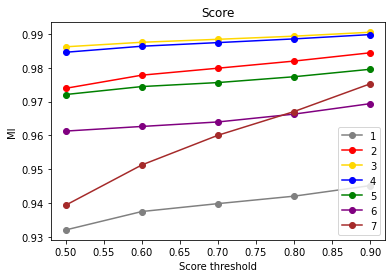

In [10]:
# MI vs. gtscore by period
percolors = ["gray","red","gold","blue","green","purple","brown"]

def PlotByScore(data, scorecol, percolors):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for period in range(1, 8):
        if period < 7:
            pdata = data[data["motif"].apply(len)==period].copy()
        else: pdata = data[data["motif"].apply(len)>=period].copy()
        print(len(pdata))
        mis = []
        ns = []
        thresh = np.arange(0.5, 1.0, 0.1)
        for t in thresh:
            mis.append(np.mean(pdata[pdata[scorecol]>=t]["MI"]))
            ns.append(pdata[pdata[scorecol]>=t].shape[0])
        ax.plot(thresh, mis, marker="o", color=percolors[period-1], label=period)
        print(mis)
    ax.set_xlabel("Score threshold")
    ax.set_ylabel("MI")
    ax.set_title(scorecol)
    ax.legend(loc="lower right")
    plt.savefig("Score_MI.pdf", dpi=1200)
    
PlotByScore(data, "Score", percolors)


In [4]:
# by method (advntr|eh|hipstr|gangstr)
by_method = data.groupby(["method"], as_index=False).agg({"MI": np.mean, "sample": len}).sort_values(["MI"], ascending=False)
by_method

,method,MI,sample
11,1|1|0|0,1.000000,430
13,1|1|1|0,1.000000,376
14,1|1|1|1,0.999305,2876
12,1|1|0|1,0.995646,1378
10,1|0|1|1,0.994867,4481
6,0|1|1|1,0.987830,11565935
5,0|1|1|0,0.986903,4731558
3,0|1|0|0,0.980847,1463666
1,0|0|1|0,0.975185,115405938
4,0|1|0|1,0.968323,969577


In [6]:
bypos = data.groupby(["method","pos","chrom"], as_index=False).agg({"MI": np.mean, "sample": len})

In [10]:
bypos[(bypos['chrom'] == "chr9") & (bypos['pos'] == 27573485)]

,method,pos,chrom,MI,sample
740305,0|0|1|1,27573485,chr9,0.946755,601


In [14]:
failed_MI = bypos[bypos['MI'] < 0.95]

for i in range(1,23):
    df = failed_MI[failed_MI['chrom'] == f'chr{i}']
    df['pos'] = "START=" + df['pos'].astype(str)
    df[['pos']].to_csv(f"failed_MI/failed_MI_chr{i}.txt", sep = "\t", header = False, index = False)
        

<ipython-input-14-65b78edd2a4f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pos'] = "START=" + df['pos'].astype(str)


,sample,MI,pos
276,HG02683,0.926375,7674
293,HG02776,0.934737,7646
462,NA10843,0.935113,7567
152,HG01683,0.935889,7643
486,NA12739,0.936510,7513


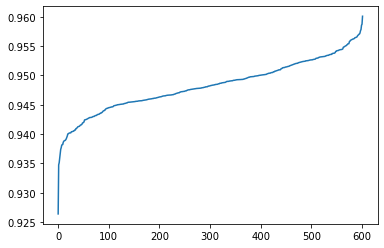

In [78]:
# by sample. check by ancestry
bysample = data.groupby("sample", as_index=False).agg({"MI": np.mean, "pos": len}).sort_values("MI")
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(bysample.shape[0]), bysample["MI"])
bysample.head()

In [18]:
full_data

,chrom,pos,motif,sample,method,gbs,MI,Score
0,chr22,11213148,AT,HG01056,0|0|1|0,"0/0,0/0,0/0",True,1.0
1,chr22,11213148,AT,HG01068,0|0|1|0,"0/0,0/0,0/0",True,1.0
2,chr22,11213148,AT,HG01071,0|0|1|0,"0/0,0/0,0/0",True,1.0
3,chr22,11213148,AT,HG01081,0|0|1|0,"0/0,0/0,0/0",True,1.0
4,chr22,11213148,AT,HG01135,0|0|1|0,"0/0,0/0,0/0",True,1.0
...,...,...,...,...,...,...,...,...
376866340,chr1,248916402,A,HG03825,0|0|1|0,"0/0,0/0,-1/0",True,1.0
376866341,chr1,248916402,A,HG04157,0|0|1|0,"0/0,-1/0,0/0",True,1.0
376866342,chr1,248916402,A,NA12801,0|0|1|0,"0/0,0/0,-1/0",True,1.0
376866343,chr1,248916402,A,NA12802,0|0|1|0,"-1/0,-1/0,0/0",True,1.0


In [29]:
ens_gangstr_21 = data[(data['method'] == "0|0|0|1") & (data['chrom'] == "chr21")]
ens_hipstr_21 = data[(data['method'] == "0|0|1|0") & (data['chrom'] == "chr21")]
ens_eh_21 = data[(data['method'] == "0|1|0|0") & (data['chrom'] == "chr21")]
ens_advntr_21 = data[(data['method'] == "1|0|0|0") & (data['chrom'] == "chr21")]
ens_advntr_21['pos'] = ens_advntr_21['pos'] - 1
ens_advntr_21

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,chrom,pos,motif,sample,method,gbs,MI,Score
2338423,chr21,30880125,AAAAAAAAG,HG00594,1|0|0|0,"0/0,-23/0,0/0",True,0.68
2338424,chr21,30880125,AAAAAAAAG,HG01258,1|0|0|0,"-50/0,0/0,0/0",False,0.98
2338425,chr21,30880125,AAAAAAAAG,HG01526,1|0|0|0,"0/0,-41/0,0/0",True,1.00
2338426,chr21,30880125,AAAAAAAAG,HG01681,1|0|0|0,"0/0,0/13,31/0",True,0.81
2338427,chr21,30880125,AAAAAAAAG,HG01881,1|0|0|0,"0/0,0/0,-14/0",True,1.00
...,...,...,...,...,...,...,...,...
4587823,chr21,45504502,AGGCCCCCC,NA20129,1|0|0|0,"-9/-9,-9/-9,-9/-9",True,1.00
4587824,chr21,45504502,AGGCCCCCC,NA20279,1|0|0|0,"-9/-9,0/-9,-9/-9",True,1.00
4587825,chr21,45504502,AGGCCCCCC,NA20358,1|0|0|0,"-9/-9,-9/-9,-9/-9",True,1.00
4587826,chr21,45505371,AGGGGGCCC,HG00423,1|0|0|0,"0/-11,0/-11,0/0",True,1.00


In [30]:
path = f"/gymreklab-tscc/helia/ensembl/1000Genomes-TR-Analysis/mend/result/mend_gt_chr21_gangstr.tab"
gangstr_21 = pd.read_csv(path, sep="\t", 
                names=["chrom","pos","motif","sample","method","gbs","MI","Score"])

path = f"/gymreklab-tscc/helia/ensembl/1000Genomes-TR-Analysis/mend/result/mend_gt_chr21_hipstr.tab"
hipstr_21 = pd.read_csv(path, sep="\t", 
                names=["chrom","pos","motif","sample","method","gbs","MI","Score"])

path = f"/gymreklab-tscc/helia/ensembl/1000Genomes-TR-Analysis/mend/result/mend_gt_chr21_eh.tab"
eh_21 = pd.read_csv(path, sep="\t", 
                names=["chrom","pos","motif","sample","method","gbs","MI","Score"])

path = f"/gymreklab-tscc/helia/ensembl/1000Genomes-TR-Analysis/mend/result/mend_gt_chr21_advntr.tab"
advntr_21 = pd.read_csv(path, sep="\t", 
                names=["chrom","pos","motif","sample","method","gbs","MI","Score"])


shared_gangstr = gangstr_21[gangstr_21['pos'].isin(ens_gangstr_21['pos'])]
shared_hipstr = hipstr_21[hipstr_21['pos'].isin(ens_hipstr_21['pos'])]
shared_advntr = advntr_21[advntr_21['pos'].isin(ens_advntr_21['pos'])]
shared_eh = eh_21[eh_21['pos'].isin(ens_eh_21['pos'])]

In [31]:
print(np.mean(shared_gangstr['sample']), np.mean(ens_gangstr_21['MI']))
print(np.mean(shared_hipstr['method']), np.mean(ens_hipstr_21['MI']))
print(np.mean(shared_eh['sample']), np.mean(ens_eh_21['MI']))
print(np.mean(shared_advntr['sample']), np.mean(ens_advntr_21['MI']))

0.8528335586342976 0.8528335586342976
0.9750044196194085 0.9750044196194085
0.9802992149311213 0.9810250898714005
0.9269796111901375 0.9269796111901375


In [32]:
print(len(shared_gangstr['MI']), len(ens_gangstr_21['MI']))
print(len(shared_hipstr['MI']), len(ens_hipstr_21['MI']))
print(len(shared_eh['MI']), len(ens_eh_21['MI']))
print(len(shared_advntr['MI']), len(ens_advntr_21['MI']))

449029 449029
1566877 1566877
27004 26983
2109 2109


In [5]:
path = f"/expanse/projects/gymreklab/helia/ensembl/1000Genomes-TR-Analysis/mend/result/mend_gt_all_advntr.tab"
data = pd.read_csv(path, sep="\t", 
    names=["chrom","pos","motif","sample","MI"])

print(len(data[data['MI'] == True]) / len(data))

0.8839061677412298


In [27]:
bypos = data.groupby(["pos","chrom","motif"], as_index=False).agg({"MI": np.mean, "sample": len}).sort_values("MI")
np.mean(bypos[bypos['sample'] > 10]['MI'])

0.8582135757556337

In [18]:
bypos

,pos,chrom,motif,MI,sample
252,9175224,chr11,AAATTTAAAATAACACAAAA,0.0,1
929,58422208,chr17,AATTCTCAATTAACAA,0.0,1
1321,103030119,chr5,AGGATTGTGGGAGGCCAAGCAGA,0.0,1
174,4304963,chr12,TTTCTTGTCTTGGACTTTTTTT,0.0,1
76,1420347,chr1,GGCCCAGGGCAGC,0.0,3
...,...,...,...,...,...
812,49691035,chr19,GGGGATAGAACGCCGGGACTCGAAGGAGGC,1.0,1
808,49650789,chr3,GCCCCCTGCCCACCAAGGCCA,1.0,1
807,49635947,chr20,CCACGGCAGGA,1.0,108
823,50269707,chr18,TGGGTTCCAGCCCATCCTCG,1.0,2
